From Mehdi's Notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import nbodykit.lab as nb
import nbodykit
import fitsio as ft
from time import time
from   glob import glob
import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

font = {'size': 16, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [2]:
from scipy.special import legendre

def RR_to_ell(RR, mu_bins, ell):
    mu_mid       = 0.5*(mu_bins[:-1]+mu_bins[1:])
    legendre_pol = (2*ell+1.)*legendre(ell)(mu_mid)
    mu_diff      = np.diff(mu_bins) 
    result       = RR * legendre_pol * mu_diff
    print(result.shape)
    RR_ell       = np.sum(result, axis=-1) / np.sum(mu_bins)
    return RR_ell    

def plot_RRellr(RR, ells=[0, 2, 4]):    
    for ell in ells:
        x   = RR.pairs.edges['r']
        y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
        dx  = np.diff(x)
        xc  = 0.5*(x[1:]+x[:-1])
        vol = 4*np.pi*xc**2*dx    
        y  /= vol
        #print(y[0])
        #y /= y[3]
        plt.plot(xc, y, label='ell=%d'%ell)
    plt.legend()
    plt.xscale('log')
    plt.xlim(.1, 4e3)
    plt.xlabel('r')
    plt.ylabel('W$^{0}_{\ell}$(r)')
    #plt.ylim(-1.5, 1.1)
    # plt.xlim(xmin=1)
    

def read_florian():    
    lbls = 'W^0_0(k) W^0_1(k) W^0_2(k) W^0_3(k) W^0_4(k) W^1_0(k)'\
        +' W^1_1(k) W^1_2(k) W^1_3(k) W^1_4(k) W^2_0(k) W^2_1(k) W^2_2(k) W^2_3(k) W^2_4(k) Nmodes'
    tlb = lbls.split(' ')    
    d = np.loadtxt('/home/mehdi/data/eboss/v6/win_eBOSS_DR16_QSO_v6_NGC_TSC_600_600_600_10000_merged.dat', 
                   skiprows=30)
    w_dicts = {}
    for i, j in enumerate(range(2, 17)):
        k = d[:, 0]
        w = d[:, j]
        w_dicts[tlb[i]] = w
    return k, w_dicts    



def plot_W0ellr(k, w_dicts, ax=None, ells=[0, 2, 4]):
    Klog = np.logspace(np.log10(k.min()), np.log10(2.0), num=1024, endpoint=True)
    if ax is None:
        fig,ax = plt.subplots(figsize=(8, 6))
    for ell in ells:
        wius = IUS(k, w_dicts['W^0_%d(k)'%ell], ext=1)
        wk   = wius(Klog)        
        print(Klog[-10:], wk[-10:])
        #for i in range(Klog.size):
        #    print([Klog[i], wk[i]])
        #break
        r, wr = mcfit.P2xi(Klog, l=ell)(wk)
        sf = 1 if ell==2 else 1
        ax.plot(r, sf*wr, label=r'$W^0_%d$'%ell)
    ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    ax.set_xlim(10, 4e3)
    # plt.ylim(0, 2.e-10)
    ax.set_xlabel('r')
    ax.legend(fontsize=20)
    
    
def plot_W0ellk(k, w_dicts, ax=None, ells=[0, 2, 4]):
    if ax is None:fig, ax = plt.subplots(figsize=(8, 6))
    for l in ells:
        w = w_dicts['W^0_%d(k)'%l]
        ax.plot(k, w, label=r'$W^0_%d$'%l, marker='.')

    #ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    #ax.set_xlim(1.e-4, 2e-2)
    #ax.set_xlim(1.e-4, 0.5)
    #plt.ylim(0, 2.e-10)
    ax.set_xlabel('k')
    ax.legend(fontsize=20)    
    
    
# def plot_RRr(RR):
#     dr = np.diff(edges)
#     plt.plot(edges[:-1], RR1d.pairs['wnpairs']/ ((4*np.pi*edges[:-1]**2*dr)))
#     plt.xscale('log')
#     plt.xlim(xmin=1)    
    
    
def plot_RRrmu(RR):
    for j, mu_j in enumerate(RR.pairs.edges['mu'][:-1]):
        #print(j)
        plt.plot(RR.pairs.edges['r'][:-1], RR.pairs['wnpairs'][:, j], label=r'$\mu$=%.1f'%mu_j)
    plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.ylabel('RR(r)')
    plt.xlabel('r')

In [3]:
class WINDOW(object):
    def __init__(self, path2file='/home/merz/workdir/emcee/eBOSS_QSO_clustering_NGC_v6.ran'):
        self.RR = nb.SurveyDataPairCount.load(path2file)
    def __call__(self, ell):
        print('ell = %d'%ell)
        x   = self.RR.pairs.edges['r']
        y   = RR_to_ell(self.RR.pairs['wnpairs'], 
                        self.RR.pairs.edges['mu'], ell)
        dx  = np.diff(x)
        xc  = 0.5*(x[1:]+x[:-1])
        vol = 4*np.pi*xc**2*dx    
        y  /= vol
        self.r  = xc
        self.wr = y
        #return xc, y        
    def Wr2Wk(self, rmin=None, rmax=None, zero=False):
        if rmin is None:
            rmin = self.r.min()
        if rmax is None:
            rmax = self.r.max()
        rgrid   = np.logspace(np.log10(rmin), np.log10(rmax), 
                              self.r.size, endpoint=True)  
        if zero:self.wr[self.r<5] = 0.0
        w_inter = IUS(self.r, self.wr, ext=1)
        #w_inter.set_smoothing_factor(100)
        wr      = w_inter(rgrid)
        k, wk   = mcfit.xi2P(rgrid)(wr)
        self.k  = k
        self.wk = wk
        self.re = rgrid
        self.wre = wr

Scaling RR_ell and smoothing at small r 

ell = 0
(99, 20)
ell = 2
(99, 20)
ell = 4
(99, 20)


(0.1, 4000.0)

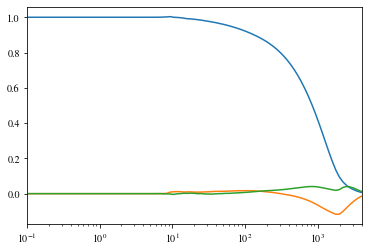

In [4]:

#(RR_0-1)exp(-(s0-s)^2)+1
R  = []
WR = []
for ell in [0,2,4]:
    win = WINDOW()
    win(ell)
    if ell==0:
        valid = (win.r >0.95) & (win.r<1.05)
        turn = (win.r >9.5) & (win.r<10.5)
        rturn = win.r[turn]
        R.append(win.r)

        scale = win.wr[turn]
        lowk0 = win.r<rturn
        low_mono =(win.wr[lowk0]/scale-1)*np.exp(-(rturn-win.r[lowk0])**2/4)+1
        highk0 = win.r>=rturn
        plt.plot(win.r,np.append(low_mono,win.wr[highk0]/scale))
        WR.append(np.append(low_mono,win.wr[highk0]/scale))

        
    if ell==2 or ell==4:
        turn = (win.r >9.5) & (win.r<10.5)
        rturn = win.r[turn]
        lowk2 = win.r<rturn
        low_ell = win.wr[lowk2]/scale*np.exp(-(rturn-win.r[lowk2])**2/4)
        highk2 = win.r>=rturn
        plt.plot(win.r,np.append(low_ell,win.wr[highk2]/scale))
        WR.append(np.append(low_ell,win.wr[highk2]/scale))
    #R.append(win.r)
    #WR.append(win.wr/scale)
    #w_inter = IUS(win.r, win.wr/scale, ext=1)
    #w_inter.set_smoothing_factor(100)
    
    #plt.plot(win.r,w_inter(win.r))

    
#plt.plot(win.r,1.5*win.r**(-.31))
#np.savetxt('/home/merz/workdir/emcee/Window/Wr_ell_norm_sm_6.txt', np.column_stack([R[0], WR[0], WR[1], WR[2], WR[3]]), header=' r W0 W2 W4 W6')
plt.xscale('log')
plt.xlim(.1, 4e3)
#plt.ylim(-0.5,1.55)
#plt.savefig('/home/merz/workdir/plots/window_norm_smooth')




Fit a power law to RR_0

In [6]:
wind.r

array([1.05774328e-01, 1.17989842e-01, 1.31616083e-01, 1.46815972e-01,
       1.63771245e-01, 1.82684623e-01, 2.03782242e-01, 2.27316353e-01,
       2.53568338e-01, 2.82852074e-01, 3.15517688e-01, 3.51955741e-01,
       3.92601900e-01, 4.37942145e-01, 4.88518578e-01, 5.44935910e-01,
       6.07868686e-01, 6.78069351e-01, 7.56377251e-01, 8.43728660e-01,
       9.41167984e-01, 1.04986024e+00, 1.17110499e+00, 1.30635188e+00,
       1.45721797e+00, 1.62550707e+00, 1.81323130e+00, 2.02263515e+00,
       2.25622233e+00, 2.51678569e+00, 2.80744062e+00, 3.13166229e+00,
       3.49332721e+00, 3.89675957e+00, 4.34678294e+00, 4.84877796e+00,
       5.40874667e+00, 6.03338424e+00, 6.73015905e+00, 7.50740199e+00,
       8.37440605e+00, 9.34153743e+00, 1.04203595e+01, 1.16237710e+01,
       1.29661604e+01, 1.44635777e+01, 1.61339266e+01, 1.79971783e+01,
       2.00756106e+01, 2.23940738e+01, 2.49802885e+01, 2.78651762e+01,
       3.10832296e+01, 3.46729250e+01, 3.86771819e+01, 4.31438768e+01,
      

In [149]:
from scipy.optimize import curve_fit

def powlaw(x,a,b):
    y = a*np.exp(x*b/4000.)
    return y

wind = WINDOW()
wind(0)
size = wind.r.size
valid = (wind.r>0.95) & (wind.r<1.05)
turn = (wind.r>9.5) & (wind.r<10.5)
rturn = wind.r[turn]
scale = wind.wr[turn]

lowk0 = wind.r<rturn
low_mono =(wind.wr[lowk0]/scale-1)*np.exp(-(rturn-wind.r[lowk0])**2/4)+1
highk0 = wind.r>=rturn

#smoothed on small scales
wrsm = np.append(low_mono, wind.wr[highk0]/scale)

#tried to see if spline improved fitting
winter = IUS(wind.r, wrsm)

ell = 0
(99, 20)


In [150]:
rlog = np.logspace(np.log10(wind.r[size-10]),np.log10(wind.r[size-1]),1000)
rhigh = np.logspace(np.log10(wind.r[size-1]),4,1000)
rfull = np.append(wind.r,rhigh)



#Fit power law to the upper range of RR_0 to try to extrapolate
params = curve_fit(powlaw, rlog, winter(rlog))
p = params[0]
print(*p)

1.4278865120977684 -5.468941026271555


(0.0001, 0.05)

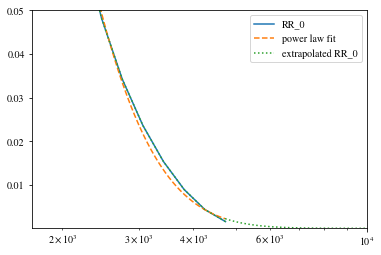

In [151]:
plt.plot(wind.r,wrsm,label='RR_0')
plt.plot(rlog,powlaw(rlog,*p),'--',label='power law fit')
plt.plot(rfull,np.append(wrsm,powlaw(rhigh,*p)),':', label='extrapolated RR_0')

plt.legend(loc=0)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(1700, 1e4)
plt.ylim(0.0001,0.05)

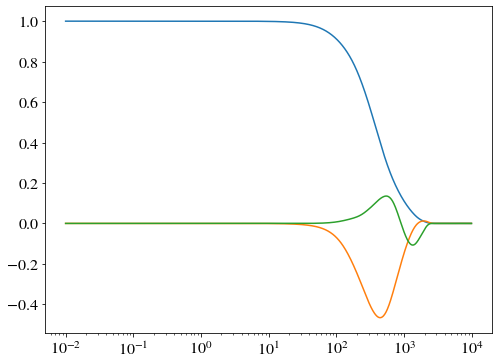

In [7]:
Florwin = np.loadtxt('/home/merz/workdir/pybird/montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z057.dat')
for i in range(1,4):
    plt.plot(Florwin[:,0],Florwin[:,i])
plt.xscale('log')




In [ ]:
def Wk2Wr(k, w):
    klog = np.logspace(np.log10(k.min()), np.log10(k.max()), 
                       num=k.size, endpoint=True)
    
    w_interpolated = IUS(k, w, ext=1)
    wk   = w_interpolated(klog)        
    return mcfit.P2xi(klog, l=0)(wk)    

class WINDOWf(object):
    def __init__(self):
        k, w_dicts = read_florian()
        self.k     = k
        self.wdict = w_dicts
        
    def __call__(self, ell, fix):
        self.ell = ell
        self.wk  = self.wdict['W^0_%d(k)'%ell]
        self._fixWk(fix) # fix Wk
        #
        
    def _fixWk(self, fix):
        if fix:
            funct     = lambda x:5.e-12*np.power(x, -3.8)
            mask      = self.k > 0.02            
            wk_last   = self.wk[~mask][-1]
            k_last    = self.k[~mask][-1]
            self.wk[mask] = funct(self.k[mask])/funct(k_last)*wk_last
            
                             
    def Wk2Wr(self, kmin=None, kmax=None):
        if kmin is None:
            kmin = self.k.min()
        if kmax is None:
            kmax = self.k.max()
        klog = np.logspace(np.log10(kmin), np.log10(kmax), 
                           num=self.k.size, endpoint=True)

        w_interpolated = IUS(self.k, self.wk, ext=1)
        wk   = w_interpolated(klog)        
        r,wr = mcfit.P2xi(klog, l=self.ell)(wk)           
        self.r = r
        self.wr= wr                
        self.ke  = klog
        self.wke = wk
        
    # def _IUS(self):
    #     funct     = lambda x:5.e-12*np.power(x, -3.8)
    #     myk       = self.k.copy()
    #     dk        = myk[1]-myk[0] 
    #     mask      = myk>=2.e-2
    #     myw       = self.wk.copy()
    #     mykc      = myk[mask]
    #     myw[mask] = funct(mykc)
    #     kextra    = np.arange(1.001*mykc.max(), 10., dk)
    #     wextra    = funct(kextra)

    #     myk_e     = np.concatenate([myk, kextra])
    #     myw_e     = np.concatenate([myw, wextra])        
    #     self.kef  = myk_e
    #     self.wkef = myw_e

    #     self.rwr_f = Wk2Wr(myk_e, myw_e)